In [2]:
from google.colab import drive
drive.mount('/content/drive/')

!unzip src.zip
!mkdir data && mkdir data/models

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  src.zip
replace src/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: src/__init__.py         
  inflating: src/data_processing.py  
  inflating: src/loader.py           
  inflating: src/dataset.py          
  inflating: src/utility.py          
mkdir: cannot create directory ‘data’: File exists


# Speech emotion recognition on ravdess

In [3]:
import seaborn as sns

from src.utility import show_duration_distribution, plot_history, plot_clusters, plot_classes, plot_encoder_loss
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader
import numpy as np

sns.set_theme()
# colab
speech_path, save_path = "drive/MyDrive/audio-pattern", "drive/MyDrive/audio-pattern"
# machine
# speech_path, save_path = "data/raw/speech", "data/processed"

EPOCHS = 500
FILE_LIMIT = -1
OVERWRITE = False

import tensorflow
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)
import warnings  
warnings.filterwarnings("ignore")

# Dataset analysis

## Audio duration
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

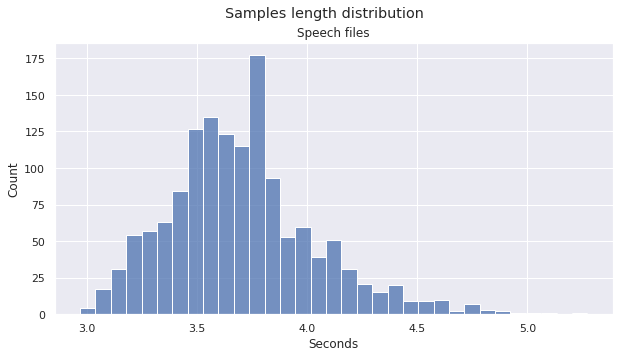

Max len of data samples:  116247.0


In [4]:
MAX_LEN = show_duration_distribution(speech_path, save_path, limit_per_actor=-1)
print("Max len of data samples: ", MAX_LEN)

## Preprocessing and feature extraction

The first step is to load all the files, padding them to a fixed size, once that is completed, the Feature Extractor obtain the features, an augmenter can be used to augment the data. For the initial visualization, identity is used as augmenter, with "classic" feature extraction.

In [5]:
loader = Loader(speech_path, save_path, True, int(MAX_LEN), FILE_LIMIT)
data, labels = loader.load(OVERWRITE)

In [6]:
from src.data_processing import identity
orig_features, orig_labels = FeatureExtractor(raw_data=data, 
                                            labels=labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="classic", 
                                            extractor=1, 
                                            augmenter=identity, 
                                            verbose=True).get_training_data(overwrite=False)

Filename: classic found on disk



In [7]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="all", train_perc=0.5, val_perc=0.2)

## Classes distribution

The class distribution is the following, this implies that we need to deal with imbalanced classes during training.

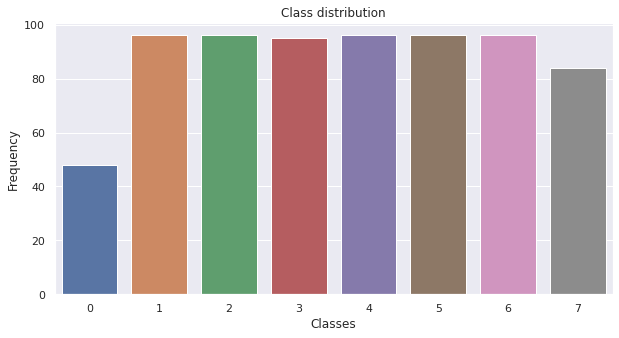

In [8]:
plot_classes(y_train)

## Data visualization
We extract the two features with most variance and plot the dataset clusters.

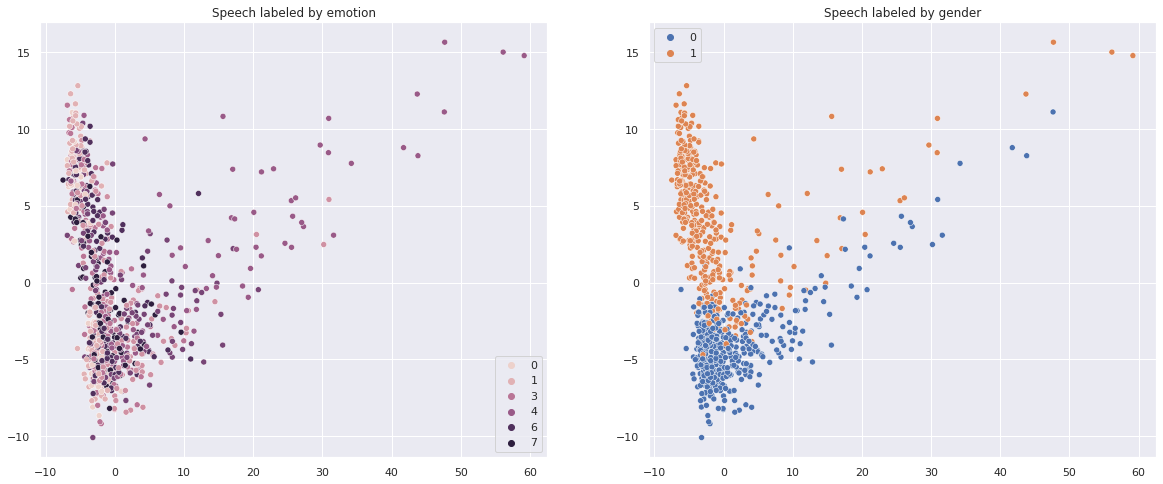

In [9]:
plot_clusters(Dataset(original_data=(orig_features, orig_labels), augmented_data=[]))

# Models training

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

## SVM training

In [10]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

from sklearn.svm import SVC

def build_train_svm(train, val, test):
  svm_model = SVC()
  svm_model.fit(train[0], train[1])
  print(f"SVM Accuracy on train: {svm_model.score(train[0], train[1])}")
  print(f"SVM Accuracy on validation:  {svm_model.score(val[0], val[1])}")
  print(f"SVM Accuracy on test:  {svm_model.score(test[0], test[1])}")

build_train_svm((X_train, y_train), (X_val, y_val), (X_test, y_test))

SVM Accuracy on train: 0.8175388967468176
SVM Accuracy on validation:  0.5809859154929577
SVM Accuracy on test:  0.5670588235294117


## KNN training
Here K is set to be sqrt of the number of training samples.

In [11]:
from sklearn.neighbors import KNeighborsClassifier as KNN

def build_train_knn(train, val, test):
  k = int(len(train[0])**(1/2))
  k += int((k%2)==0)

  knn_model = KNN(k)
  knn_model.fit(train[0], train[1])    
  print(f"{k}-NN Accuracy on train: {knn_model.score(train[0], train[1])}")
  print(f"{k}-NN Accuracy on validation:  {knn_model.score(val[0], val[1])}")
  print(f"{k}-NN Accuracy on test:  {knn_model.score(test[0], test[1])}")

build_train_knn((X_train, y_train), (X_val, y_val), (X_test, y_test))

27-NN Accuracy on train: 0.5233380480905233
27-NN Accuracy on validation:  0.4014084507042254
27-NN Accuracy on test:  0.4164705882352941


## Neural network training


In [12]:
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2

from collections import Counter
import numpy as np

def class_weight(y):
    seq = y.copy().reshape(y.shape[0])
    t, L = len(np.unique(seq)), len(seq)
    return {k : L/(t*v) for k, v in Counter(seq).items()}

def build_nn():
    model = Sequential()
    model.add(Input(shape=X_train[0].shape))
    model.add(Dense(150, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.25))
    model.add(Dense(75, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

def train_nn(train_data, val_data, test_data, build_fun, epochs, verbose):
    
    m = build_fun()
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="data/models/nn.hdf5",
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    w = class_weight(train_data[1])

    history = m.fit(train_data[0], train_data[1], validation_data=val_data, 
                        epochs=epochs, verbose=verbose, callbacks=[model_checkpoint_callback], class_weight=w)
    plot_history(history)
    
    m.load_weights("data/models/nn.hdf5")
    l, a = m.evaluate(test_data[0], test_data[1], verbose=0)
    print(f"TEST: Loss: {l}, accuracy: {a}")
    return m, history

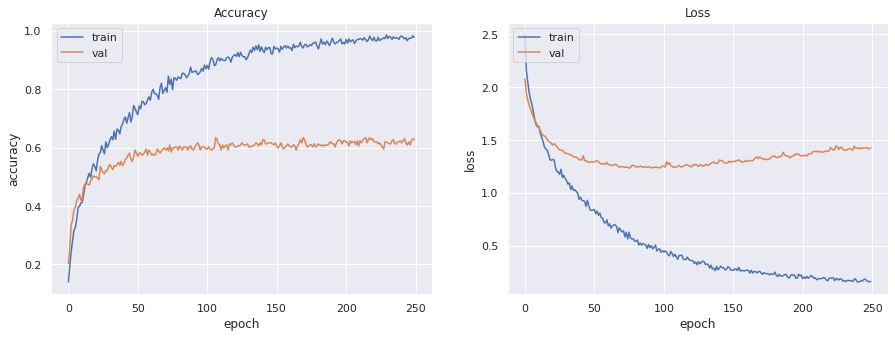

TEST: Loss: 1.2568737268447876, accuracy: 0.6117647290229797


In [14]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)
model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=250, verbose=0)

## Results and data augmentation
Performance on test is quite poor, we now apply augmentation to the data, in the form of noise, speed and pitch and stretch.
The test data is obtained from the original dataset, while training and validation contains the augmented data.

In [15]:
# parameters after path are not so important, as the raw data is precomputed
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)
OVERWRITE = False

from src.data_processing import identity, noise, stretch, speedpitch

orig_features, orig_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="classic", 
                                              extractor=0, augmenter=identity, verbose=True).get_training_data(overwrite=OVERWRITE)

noise_features, noise_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="noise_classic", 
                                                extractor=0, augmenter=noise, verbose=True).get_training_data(overwrite=OVERWRITE)

stretch_features, stretch_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="stretch_classic", 
                                                    extractor=0, augmenter=stretch, verbose=True).get_training_data(overwrite=OVERWRITE)

speed_features, speed_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="speed_classic", 
                                                extractor=0, augmenter=speedpitch, verbose=True).get_training_data(overwrite=OVERWRITE)

original_data = (orig_features, orig_labels)
augmented_data = [(noise_features, noise_labels), (stretch_features, stretch_labels), (speed_features, speed_labels)]

d = Dataset(original_data=original_data, augmented_data=augmented_data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

Filename: classic found on disk

Filename: noise_classic found on disk

Filename: stretch_classic found on disk

Filename: speed_classic found on disk



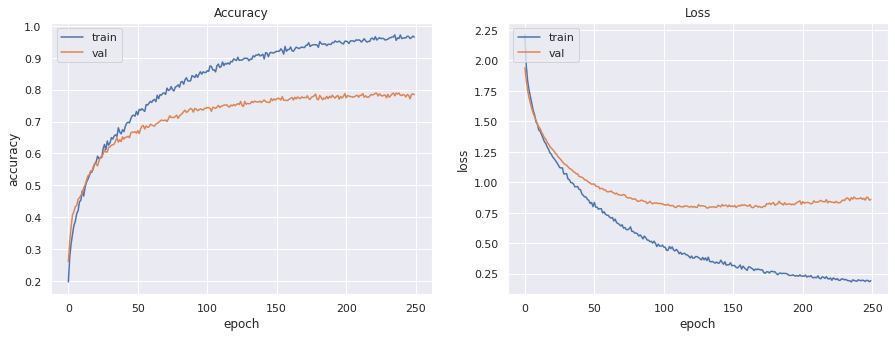

TEST: Loss: 1.615960955619812, accuracy: 0.6658823490142822


In [16]:
model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=250, verbose=0)

In [17]:
build_train_svm((X_train, y_train), (X_val, y_val), (X_test, y_test))

SVM Accuracy on train: 0.7859413634758036
SVM Accuracy on validation:  0.6345984112974404
SVM Accuracy on test:  0.6047058823529412


In [18]:
build_train_knn((X_train, y_train), (X_val, y_val), (X_test, y_test))

53-NN Accuracy on train: 0.481808548216178
53-NN Accuracy on validation:  0.40158870255957635
53-NN Accuracy on test:  0.43058823529411766


Performance increase among all models

## Auto encoders

We now try to perform some pre-training with auto-encoders to see if performance increases. They are trained with only the augmented train split. 

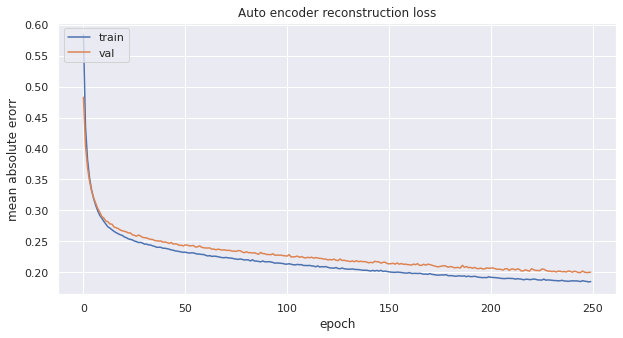

In [19]:
N = 312
n_mid = int(N*2/3)
n_bottleneck = N//2

# encoder
visible = Input(shape=X_train[0].shape)
e = Dense(n_mid, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(visible)
# bottleneck
bottleneck = Dense(n_bottleneck, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(e)
# decoder
d = Dense(n_mid, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(bottleneck)
# output
output = Dense(N, activation='linear')(d)
model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mae')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="data/models/autoenc.hdf5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(X_train, X_train, epochs=250, verbose=0, validation_data=(X_val,X_val), callbacks=[model_checkpoint_callback])
model.load_weights("data/models/autoenc.hdf5")
plot_encoder_loss(history)

# get encoder from input to bottleneck
encoder = Model(inputs=visible, outputs=bottleneck)

X_train_encode = encoder.predict(X_train)
X_val_encode = encoder.predict(X_val)
X_test_encode = encoder.predict(X_test)

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
s.fit(X_train_encode)
X_train_encode = s.transform(X_train_encode)
X_val_encode = s.transform(X_val_encode)
X_test_encode = s.transform(X_test_encode)

In [20]:
build_train_svm((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test))

SVM Accuracy on train: 0.8053691275167785
SVM Accuracy on validation:  0.6566637246248896
SVM Accuracy on test:  0.6423529411764706


In [21]:
build_train_knn((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test))

53-NN Accuracy on train: 0.493465206640763
53-NN Accuracy on validation:  0.4324801412180053
53-NN Accuracy on test:  0.47058823529411764


Epoch 1/250
89/89 - 2s - loss: 2.1392 - accuracy: 0.1816 - val_loss: 2.0253 - val_accuracy: 0.2101 - 2s/epoch - 22ms/step
Epoch 2/250
89/89 - 1s - loss: 2.0092 - accuracy: 0.2402 - val_loss: 1.9383 - val_accuracy: 0.2736 - 535ms/epoch - 6ms/step
Epoch 3/250
89/89 - 1s - loss: 1.9186 - accuracy: 0.2858 - val_loss: 1.8835 - val_accuracy: 0.3239 - 536ms/epoch - 6ms/step
Epoch 4/250
89/89 - 0s - loss: 1.8494 - accuracy: 0.3147 - val_loss: 1.8224 - val_accuracy: 0.3619 - 385ms/epoch - 4ms/step
Epoch 5/250
89/89 - 0s - loss: 1.7908 - accuracy: 0.3497 - val_loss: 1.7762 - val_accuracy: 0.3778 - 310ms/epoch - 3ms/step
Epoch 6/250
89/89 - 0s - loss: 1.7323 - accuracy: 0.3727 - val_loss: 1.7290 - val_accuracy: 0.4042 - 318ms/epoch - 4ms/step
Epoch 7/250
89/89 - 0s - loss: 1.6816 - accuracy: 0.3963 - val_loss: 1.6890 - val_accuracy: 0.4210 - 351ms/epoch - 4ms/step
Epoch 8/250
89/89 - 0s - loss: 1.6248 - accuracy: 0.4133 - val_loss: 1.6471 - val_accuracy: 0.4422 - 398ms/epoch - 4ms/step
Epoch 9/25

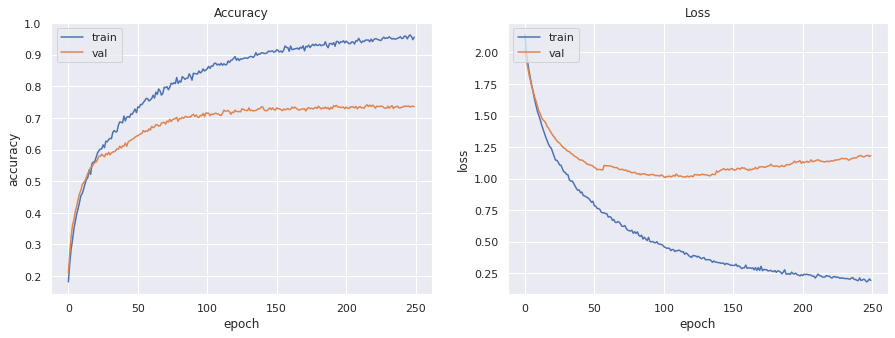

TEST: Loss: 1.7719286680221558, accuracy: 0.6611764430999756
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               20096     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 264       
                                                                 
Total params: 24,488
Trainable params: 24,488
Non-trainable params: 0
_______________________________________________________

In [23]:
def build_nn_enc():
    model = Sequential()
    model.add(Input(shape=X_train_encode[0].shape))
    model.add(Dense(128, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

model, history = train_nn((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test), build_nn_enc, epochs=250, verbose=2)
model.summary()

Embedding the features in a smaller space seems to help SVM, but not really NN

## Convolutional neural network

In [24]:
# parameters after path are not so important, as the raw data is precomputed
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)
OVERWRITE = False
from src.data_processing import identity, noise, stretch, speedpitch

orig_features, orig_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="cnn", 
                                              extractor=1, augmenter=identity, verbose=True).get_training_data(overwrite=OVERWRITE)

noise_features, noise_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="noise_cnn", 
                                                extractor=1, augmenter=noise, verbose=True).get_training_data(overwrite=OVERWRITE)

stretch_features, stretch_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="stretch_cnn", 
                                                    extractor=1, augmenter=stretch, verbose=True).get_training_data(overwrite=OVERWRITE)

speed_features, speed_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="speed_cnn", 
                                                extractor=1, augmenter=speedpitch, verbose=True).get_training_data(overwrite=OVERWRITE)

original_data = (orig_features, orig_labels)
# augmented_data = [(noise_features, noise_labels), (stretch_features, stretch_labels), (speed_features, speed_labels)]
augmented_data = [(noise_features, noise_labels), (speed_features, speed_labels)]

Filename: cnn found on disk

Filename: noise_cnn found on disk

Filename: stretch_cnn found on disk

Filename: speed_cnn found on disk



In [25]:
d = Dataset(original_data=original_data, augmented_data=augmented_data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

In [45]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

def build_cnn():
    cnn = tf.keras.Sequential()
    cnn.add(Conv1D(32, kernel_size=(12), activation='relu', input_shape=(X_train[0].shape[0], 1), kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4)))
    cnn.add(Conv1D(64, kernel_size=(12),activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4)))
    cnn.add(MaxPooling1D(pool_size=(8)))
    cnn.add(Dropout(0.3))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(8, activation='softmax'))
    cnn.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return cnn

Epoch 1/350
67/67 - 1s - loss: 2.0765 - accuracy: 0.2459 - val_loss: 1.9181 - val_accuracy: 0.3000 - 1s/epoch - 21ms/step
Epoch 2/350
67/67 - 0s - loss: 1.8894 - accuracy: 0.3114 - val_loss: 1.8548 - val_accuracy: 0.3188 - 353ms/epoch - 5ms/step
Epoch 3/350
67/67 - 0s - loss: 1.8069 - accuracy: 0.3500 - val_loss: 1.8107 - val_accuracy: 0.3271 - 430ms/epoch - 6ms/step
Epoch 4/350
67/67 - 0s - loss: 1.7452 - accuracy: 0.3646 - val_loss: 1.7549 - val_accuracy: 0.3635 - 430ms/epoch - 6ms/step
Epoch 5/350
67/67 - 0s - loss: 1.6949 - accuracy: 0.3910 - val_loss: 1.7318 - val_accuracy: 0.3847 - 342ms/epoch - 5ms/step
Epoch 6/350
67/67 - 0s - loss: 1.6577 - accuracy: 0.4089 - val_loss: 1.7159 - val_accuracy: 0.3694 - 336ms/epoch - 5ms/step
Epoch 7/350
67/67 - 0s - loss: 1.5961 - accuracy: 0.4249 - val_loss: 1.6806 - val_accuracy: 0.4318 - 347ms/epoch - 5ms/step
Epoch 8/350
67/67 - 0s - loss: 1.5595 - accuracy: 0.4291 - val_loss: 1.6682 - val_accuracy: 0.4247 - 325ms/epoch - 5ms/step
Epoch 9/35

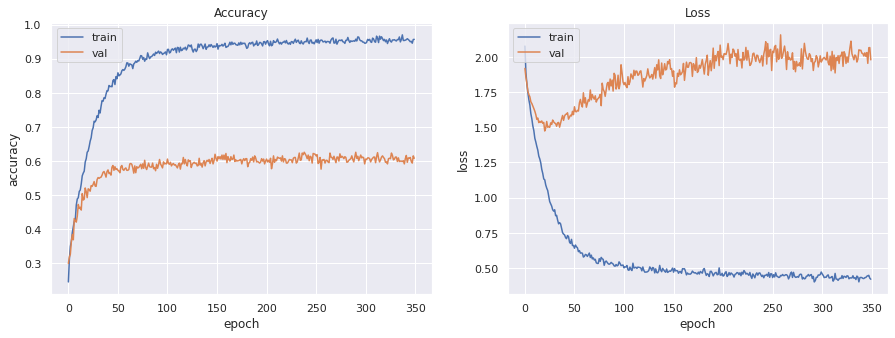

TEST: Loss: 2.7340004444122314, accuracy: 0.5364705920219421
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 217, 32)           416       
                                                                 
 conv1d_17 (Conv1D)          (None, 206, 64)           24640     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 dropout_28 (Dropout)        (None, 25, 64)            0         
                                                                 
 flatten_9 (Flatten)         (None, 1600)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               409

In [46]:
model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_cnn, epochs=350, verbose=2)
model.summary()

## 2D Network

In [47]:
# parameters after path are not so important, as the raw data is precomputed
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)
OVERWRITE = False
from src.data_processing import identity, noise, stretch, speedpitch

orig_features, orig_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="2d_cnn", 
                                              extractor=2, augmenter=identity, verbose=True).get_training_data(overwrite=OVERWRITE)

noise_features, noise_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="2d_noise_cnn", 
                                                extractor=2, augmenter=noise, verbose=True).get_training_data(overwrite=OVERWRITE)

stretch_features, stretch_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="2d_stretch_cnn", 
                                                    extractor=2, augmenter=stretch, verbose=True).get_training_data(overwrite=OVERWRITE)

speed_features, speed_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="2d_speed_cnn", 
                                                extractor=2, augmenter=speedpitch, verbose=True).get_training_data(overwrite=OVERWRITE)

original_data = (orig_features, orig_labels)
# augmented_data = [(noise_features, noise_labels), (stretch_features, stretch_labels), (speed_features, speed_labels)]
augmented_data = [(noise_features, noise_labels), (speed_features, speed_labels)]

Filename: 2d_cnn found on disk

Filename: 2d_noise_cnn found on disk

Filename: 2d_stretch_cnn found on disk

Filename: 2d_speed_cnn found on disk



In [48]:
d = Dataset(original_data=original_data, augmented_data=augmented_data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

In [55]:
from keras.layers import Conv2D, MaxPooling2D
def build_2d_cnn():
    cnn = tf.keras.Sequential()
    cnn.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(*X_train[0].shape, 1)))
    cnn.add(Conv2D(64, kernel_size=(7, 7),activation='relu', kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01)))
    cnn.add(MaxPooling2D(pool_size=(9, 9)))
    cnn.add(Dropout(0.25))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(8, activation='softmax'))
    cnn.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return cnn

Epoch 1/250
67/67 [==============================] - 8s 104ms/step - loss: 2.8241 - accuracy: 0.1239 - val_loss: 2.5043 - val_accuracy: 0.1494
Epoch 2/250
67/67 [==============================] - 7s 100ms/step - loss: 2.2973 - accuracy: 0.2228 - val_loss: 2.0949 - val_accuracy: 0.2565
Epoch 3/250
67/67 [==============================] - 7s 102ms/step - loss: 2.0545 - accuracy: 0.3118 - val_loss: 1.9466 - val_accuracy: 0.3412
Epoch 4/250
67/67 [==============================] - 7s 100ms/step - loss: 1.8544 - accuracy: 0.3570 - val_loss: 1.7266 - val_accuracy: 0.3906
Epoch 5/250
67/67 [==============================] - 7s 99ms/step - loss: 1.6840 - accuracy: 0.3971 - val_loss: 1.6350 - val_accuracy: 0.4047
Epoch 6/250
67/67 [==============================] - 7s 99ms/step - loss: 1.5588 - accuracy: 0.4451 - val_loss: 1.5619 - val_accuracy: 0.4318
Epoch 7/250
67/67 [==============================] - 7s 98ms/step - loss: 1.4729 - accuracy: 0.4762 - val_loss: 1.4683 - val_accuracy: 0.4824
Ep

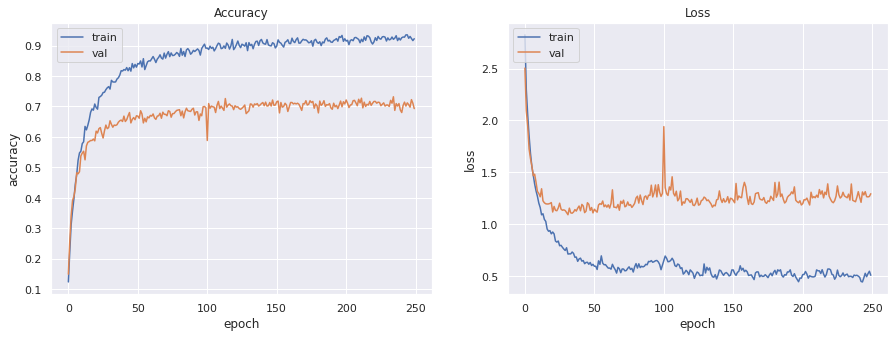

TEST: Loss: 1.7727775573730469, accuracy: 0.6399999856948853
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 224, 32)      832       
                                                                 
 conv2d_7 (Conv2D)           (None, 118, 218, 64)      100416    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_36 (Dropout)        (None, 13, 24, 64)        0         
                                                                 
 flatten_13 (Flatten)        (None, 19968)             0         
                                                                 
 dense_45 (Dense)            (None, 256)               511

In [56]:
model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_2d_cnn, epochs=250, verbose=1)
model.summary()